# Financial Youtube Channel - Data Analysis and Visualization
## Background Information
### Introduction
Since its inception, Youtube has grown to become one of the biggest platforms for content creators in the world, processing billions of searches per month. However, there are myths as to how the Youtube algorithm works, what makes certain videos get more views than others, etc. If you've been watching Youtube, you oftentimes hear content creators telling you to like, comment, and subscribe to help promote their videos. While this might not necessarily be the case, it certainly is worth exploring to look for certain factors that may support this claim. That is exactly what I am going to be doing in this notebook, along with identifying trends among certain Youtube channels with a particular niche or topic. <br><br>
As a retail investor, I've decided to analyze various financial Youtube channels that I've been following; most of channels talk about the stock market. What I hope to gain are some insights from these content to help me better understand the Youtube investing landscape, such as the most-talked about topic/stock. Please note that the scope of this project is small; you will see that I've analyzed 9 of my favorite investment channels. To gather these data and create my own dataset, I used the [Google Youtube Data API v3](https://developers.google.com/youtube/v3/).

### Objectives
In this project, I am looking to answering the following questions:
- What is the total view count by channel?
- What is the video distribution like based on the day uploaded? How about when based on the month?
- What is the relationship like between the view count and comment count? View and tags? View and like?
- What is the video distribution like based on duration?
- For each channel, what is the comment and view distribution like?
- What is the average view count for each channel based on upload day?
- (Natural Language Processing Question) What are some of the most used words in the video titles for all channel?
- (Natural Language Processing Question) What are some of the most used words in the video comments for all channels?
- Does title length affect view count?

### Steps 
1. Gathering Data With Youtube API
2. Pre-Processing/Cleaning
3. Exploratory Data Analysis
4. Conclusions

### Data Limitation
The dataset that I've gathered is real-world dataset gathered from Youtube itself. However, please keep in mind that the channels that I've gathered are purely my decisions and they do not represent the "popular" channels based on number of subscribers. The channels collected are based on what I follow and deem as 'good' investment channels. Also, I wanted to include a dislike count, but, as of today(3/20/22), the youtube dislike feature has been disabled. 

In [22]:
import pandas as pd
import googleapiclient.discovery
from IPython.display import JSON
import itertools

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline
import seaborn as sb
import imageio
import isodate

#NLP
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

## Gathering Data With Youtube API
For my first step, I created a project on Google Developers Console and requested an API key which then allowd me to enabled Youtube API for my application. Afterwards, I gathered all the channel IDs that I'm interested in analyzing. Lastly, I created functions for gathering all the data and statistics that I need.

In [23]:
api_key = ['HIDDEN'] # API key is hidden for security purposes

In [24]:
# list of channels that I am interested 
channel_ids = ['UCbta0n8i6Rljh0obO7HzG9A','UCfCT7SSFEWyG4th9ZmaGYqQ',
               'UCJwKCyEIFHwUOPQQ-4kC1Zw','UCxwoFvCK8RCq9J4RbIW2qrQ', 'UCL-F-8nxFtFZ4M3RWkGn6Qw',
               'UCO3tlaeZ6Z0ZN5frMZI3-uQ', 'UCkcnYVAVZQOB-nXHechtXDg', 'UCZ5V5HyAvkFrjsWkANqXscQ',
               'UC7r4-nZ4icT8SIcnisXFSHQ']

In [25]:
api_service_name = "youtube"
api_version = "v3"
# Get credentials and create an API client
youtube = googleapiclient.discovery.build(
    api_service_name, api_version, developerKey=api_key)

In [26]:
def get_channel_stats(youtube, channel_ids):
    """
    Function: Gather interested channel stats from youtube creator's channel page
    
    INPUT:
    youtube - build object from googleapiclient.discovery
    channel_ids - (list) list of channel ids to be analyzed
    
    OUTPUT:
    all_data - (pandas dataframe) dataframe that consists of the following columns: channelName, publishDate, subscribers, views, totalVideos, playlistId
    """
    all_data = []

    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    response = request.execute()
    
    #loop through items
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'publishDate': item['snippet']['publishedAt'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalVideos': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
        }
        all_data.append(data)
    all_data = pd.DataFrame(all_data)

    return(all_data)

In [27]:
def get_videos_ids(youtube, playlist_id):
    """
    Function: Gather videoIds from channel. 
    
    INPUT:
    youtube - Get credentials and create an API client/Initialise a Youtube API service object.
    playlist_ids - (list) list of playlist ids to be analyzed.
    
    OUTPUT:
    video_ids - (list) list of dictionary that contains all videoId for channel.
    """
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet, contentDetails",
        playlistId= playlist_id,
        maxResults = 50
    )
    
    response = request.execute()
    
    for item in response['items']:
        data = {
                'videoId': item['contentDetails']['videoId']
               }
        video_ids.append(data)
    
    next_page_token = response.get('nextPageToken')  
    while next_page_token is not None:
        request = youtube.playlistItems().list(
            part="snippet, contentDetails",
            playlistId= playlist_id,
            maxResults = 50,
            pageToken = next_page_token
            )
        response = request.execute()

        for item in response['items']:
            data = {
                    'videoId': item['contentDetails']['videoId']
               }
            video_ids.append(data)
        next_page_token = response.get('nextPageToken')
        
    return video_ids

In [28]:
def get_video_details(youtube, video_ids):
    """
    Function: Gather interested information from videos and store in dataframe. 
    
    INPUT:
    youtube - Get credentials and create an API client/Initialise a Youtube API service object.
    video_ids - (list) list of video ids.
    
    OUTPUT:
    video_df - (pandas dataframe) dataframe of video statistics. Includes columns:
                 'channelTitle', 'title', 'description', 'tags', 'publishedAt',
                 'viewCount', 'likeCount', 'favouriteCount', 'commentCount',
                 'duration', 'definition', 'caption'%
    """
    all_video_info = []
    for i in range(0,len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id= ','.join(video_ids[i:i+50])
        )
        response = request.execute()

        for video in response['items']:
            # create dictionary of stats I want to keep
            stats_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                          'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                          'contentDetails': ['duration', 'definition', 'caption']
                        }
            
            # empty dictionary to keep track of keys and values
            video_info = {}
            video_info['video_id'] = video['id']
            
            # extract values and append them into empty dictionary
            for k in stats_keep.keys():
                for v in stats_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
        video_df = pd.DataFrame(all_video_info)
    return video_df

In [29]:
def get_videos_comments(youtube, video_ids):
    """
    Function: Gather comments from videos and store in dataframe. 
    
    INPUT:
    youtube - Get credentials and create an API client/Initialise a Youtube API service object.
    video_ids - (list) list of video ids.
    
    OUTPUT:
    all_comments_df - (pandas dataframe) dataframe of comments. Each video has a max of 
                        10 comments which are compiled in a list.
    """
    all_comments = []
    
    for video_id in video_ids:
        try:
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()
            # help https://developers.google.com/youtube/v3/docs/commentThreads?hl=en_US#snippet.topLevelComment
            video_comments = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] 
                              for comment in response['items'][0:10]]
            video_comments_info = {'video_id': video_id, 'comments': video_comments}
            all_comments.append(video_comments_info)
        except:
            # dealing with errors
            pass 
            
    all_comments_df = pd.DataFrame(all_comments)
    return all_comments_df
        

### Gathering Channel Statistics

In [31]:
channel_stats = get_channel_stats(youtube, channel_ids)
channel_stats

,channelName,publishDate,subscribers,views,totalVideos,playlistId
0,Benjamin,2021-02-02T15:23:39.467329Z,283000,15877118,32,UUkcnYVAVZQOB-nXHechtXDg
1,Cents Invest,2019-03-22T21:32:26Z,92600,2992449,287,UUxwoFvCK8RCq9J4RbIW2qrQ
2,Dividend Data,2020-04-19T20:17:08.795625Z,96400,4886681,83,UUZ5V5HyAvkFrjsWkANqXscQ
3,Joseph Carlson After Hours,2017-02-14T04:41:26Z,53900,2810611,85,UUfCT7SSFEWyG4th9ZmaGYqQ
4,Joseph Carlson,2013-09-19T17:32:49Z,240000,16335202,235,UUbta0n8i6Rljh0obO7HzG9A
5,Nate O'Brien,2016-12-31T06:50:03Z,1230000,63768501,183,UUO3tlaeZ6Z0ZN5frMZI3-uQ
6,Daniel Pronk,2015-12-17T20:49:02Z,197000,9107258,193,UUL-F-8nxFtFZ4M3RWkGn6Qw
7,The Investor Channel,2016-02-16T23:11:03Z,113000,6947619,568,UU7r4-nZ4icT8SIcnisXFSHQ
8,Tom Nash,2017-08-15T13:06:55Z,282000,35674132,535,UUJwKCyEIFHwUOPQQ-4kC1Zw


### Gathering Video Statistics For All Channels
In this step, I will be gathering the video statitics for all the channels. In total, there are 2201 rows of videos and 13 columns in the dataset.

In [32]:
playlist_ids = list(channel_stats.playlistId.unique()) # convert all unique calues in playlistId into a list
video_ids_list = []

# loop to get video ids from all interested channels
for playlist_id in playlist_ids:
    video_ids = get_videos_ids(youtube, playlist_id)
    video_ids_list.append(video_ids)
video_ids_list

[[{'videoId': 'jm55pm_ZIdI'},
  {'videoId': '9ZVvgxLhs2M'},
  {'videoId': 'v3NUSNQafYM'},
  {'videoId': 'YUcdYDQJkBU'},
  {'videoId': 'CSz67F0ZS0w'},
  {'videoId': 'KgH4rDtxqHg'},
  {'videoId': 'iFBoOGMjxI0'},
  {'videoId': 'ZN6P9ErUcOg'},
  {'videoId': '1UY0uS6Z6oE'},
  {'videoId': 'Mvixia9iUWs'},
  {'videoId': '2Zus6SyQhW4'},
  {'videoId': 'CWXvIwv3pg4'},
  {'videoId': '8pYgz4YlQnE'},
  {'videoId': 'DEA2sCE2CJs'},
  {'videoId': '8QaP43sFO5A'},
  {'videoId': 'TrTeLB8F98k'},
  {'videoId': 'TMO42qkPiio'},
  {'videoId': 'dgisRHEQ2FM'},
  {'videoId': '80BXR4zX2EE'},
  {'videoId': 'DJZRUryrZnc'},
  {'videoId': '8fqGgIYggig'},
  {'videoId': '7qrQbsJTiTA'},
  {'videoId': 'DMw10sVuQn4'},
  {'videoId': 'E7-e7NeoQzA'},
  {'videoId': 'p1nBso5XkHo'},
  {'videoId': 'SqpJ-hTRhsM'},
  {'videoId': 'xr2DfWmQ4_Y'},
  {'videoId': 'WCD58idv_U0'},
  {'videoId': 'NW5927_LPUs'},
  {'videoId': 'XYZqrkHTGo8'},
  {'videoId': 'FEMFVM1PskM'},
  {'videoId': 'XKPmtbCmkE4'}],
 [{'videoId': '-dd2dTKg0-g'},
  {'video

In [33]:
# chain all lists into one giant list
video_ids_list_clean= list(itertools.chain(*video_ids_list))
# only get video id value(str) and put into list
video_ids_list_clean = [d['videoId'] for d in video_ids_list_clean]

In [34]:
video_ids = video_ids_list_clean
video_df = get_video_details(youtube, video_ids)
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,jm55pm_ZIdI,Benjamin,Investing Backtests That Make Me Sad,Subscribe to The Daily Upside using the link b...,None,2022-03-15T15:00:25Z,149302,9150,None,1130,PT9M3S,hd,false
1,9ZVvgxLhs2M,Benjamin,More Awful TikTok Trading Strategies?,Make sure to get a 30 day free trial for Predi...,None,2022-02-18T16:00:03Z,199238,10708,None,1139,PT14M10S,hd,false
2,v3NUSNQafYM,Benjamin,Beat the Market with Scary Youtube Finance Thu...,Subscribe to The Daily Upside! \nhttps://bit.l...,None,2022-01-30T16:00:26Z,193013,12214,None,974,PT10M42S,hd,false
3,YUcdYDQJkBU,Benjamin,The Stock Market Geniuses of Fiverr,Subscribe to The Daily Upside! \nhttps://bit.l...,None,2022-01-12T16:00:16Z,258173,12673,None,920,PT10M8S,hd,false
4,CSz67F0ZS0w,Benjamin,Testing the Biggest TikTok Daytrader's Course,https://www.patreon.com/givebenyourmoney\n\nHa...,None,2021-12-23T16:00:05Z,548906,29512,None,2039,PT11M59S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2196,lnr5ak4_fgg,Tom Nash,The Contrepreneur Formula Exposed - Mike Winne...,The CONtrepreneur Formula: Exposed is a video ...,"[mike winnet, mike winnet coffeezilla, mike wi...",2020-06-17T11:41:13Z,8731,385,None,63,PT11M10S,hd,false
2197,W0ZUSb8FVL8,Tom Nash,Why Spotify bought Joe Rogan’s podcast (The RE...,Joe Rogan just signed a huge multiyear deal wi...,"[joe rogan spotify podcast, joe rogan spotify,...",2020-05-22T13:03:38Z,7261,281,None,109,PT10M2S,hd,false
2198,Xa-EtGhD3F8,Tom Nash,FED Desperately Trying to Prevent a Total Coll...,"In economics, a depression is a sustained, lon...",[FED tries low interest rates to prevent a Dep...,2020-05-13T19:10:21Z,1598,84,None,32,PT7M,hd,false
2199,XBKVM07pzIk,Tom Nash,Wow! The FED just did something that may DESTR...,The FED (Federal Reserve) recently announced t...,"[the federal reserve, the federal reserve cras...",2020-05-10T12:04:10Z,4134,212,None,76,PT11M13S,hd,false


### Gathering Video comments For All Channels

In [35]:
all_comments_df = get_videos_comments(youtube, video_ids)
all_comments_df

,video_id,comments
0,jm55pm_ZIdI,[Subscribe to The Daily Upside!\nhttps://bit.l...
1,9ZVvgxLhs2M,[I consistently earn massively on my investmen...
2,v3NUSNQafYM,[Subscribe to The Daily Upside! \nhttps://bit....
3,YUcdYDQJkBU,[Subscribe to The Daily Upside!\nhttps://bit.l...
4,CSz67F0ZS0w,[I was trading options during the cold war LMA...
...,...,...
2195,lnr5ak4_fgg,"[Mike is a national treasure lolz, garden veri..."
2196,W0ZUSb8FVL8,[Hit the subscribe button to join the Squad 🛑 ...
2197,Xa-EtGhD3F8,[Hit the subscribe button to join the Squad 🛑 ...
2198,XBKVM07pzIk,[Hit the subscribe button to join the Squad 🛑 ...


## Data Pre-Processing/Cleaning
To make sure that the entire analysis process run smoothly, I will now be conducting the cleaning phase of the data analysis process. Please continue reading to see how and what I changed to make the dataset clean and tidy. 

In [36]:
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount          True
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [37]:
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [38]:
video_df.definition.unique()

array(['hd', 'sd'], dtype=object)

In [39]:
video_df.describe()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
count,2201,2201,2201,2201,1386,2201,2201,2200,0,2201,2201,2201,2201
unique,2201,9,2200,2109,1175,2201,2176,1700,0,764,1315,2,2
top,jm55pm_ZIdI,The Investor Channel,How Warren Buffett Values Stocks,,"[The Joseph Carlson Show, investing, stocks, s...",2022-03-15T15:00:25Z,4339,175,NaN,27,PT8M1S,hd,false
freq,1,568,2,24,85,1,2,7,NaN,21,9,2199,2167


In [40]:
all_comments_df.isnull().sum()

video_id    0
comments    0
dtype: int64

**`1.` Convert 'viewCount','likeCount','favouriteCount', 'commentCount' columns to numeric data types.**

In [41]:
num_cols = ['viewCount','likeCount','favouriteCount', 'commentCount']
video_df[num_cols] = video_df[num_cols].apply(pd.to_numeric, errors = 'coerce', axis =1)

#Check
video_df.dtypes

video_id           object
channelTitle       object
title              object
description        object
tags               object
publishedAt        object
viewCount         float64
likeCount         float64
favouriteCount    float64
commentCount      float64
duration           object
definition         object
caption            object
dtype: object

In [42]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,jm55pm_ZIdI,Benjamin,Investing Backtests That Make Me Sad,Subscribe to The Daily Upside using the link b...,None,2022-03-15T15:00:25Z,149302.0,9150.0,NaN,1130.0,PT9M3S,hd,false
1,9ZVvgxLhs2M,Benjamin,More Awful TikTok Trading Strategies?,Make sure to get a 30 day free trial for Predi...,None,2022-02-18T16:00:03Z,199238.0,10708.0,NaN,1139.0,PT14M10S,hd,false
2,v3NUSNQafYM,Benjamin,Beat the Market with Scary Youtube Finance Thu...,Subscribe to The Daily Upside! \nhttps://bit.l...,None,2022-01-30T16:00:26Z,193013.0,12214.0,NaN,974.0,PT10M42S,hd,false
3,YUcdYDQJkBU,Benjamin,The Stock Market Geniuses of Fiverr,Subscribe to The Daily Upside! \nhttps://bit.l...,None,2022-01-12T16:00:16Z,258173.0,12673.0,NaN,920.0,PT10M8S,hd,false
4,CSz67F0ZS0w,Benjamin,Testing the Biggest TikTok Daytrader's Course,https://www.patreon.com/givebenyourmoney\n\nHa...,None,2021-12-23T16:00:05Z,548906.0,29512.0,NaN,2039.0,PT11M59S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2196,lnr5ak4_fgg,Tom Nash,The Contrepreneur Formula Exposed - Mike Winne...,The CONtrepreneur Formula: Exposed is a video ...,"[mike winnet, mike winnet coffeezilla, mike wi...",2020-06-17T11:41:13Z,8731.0,385.0,NaN,63.0,PT11M10S,hd,false
2197,W0ZUSb8FVL8,Tom Nash,Why Spotify bought Joe Rogan’s podcast (The RE...,Joe Rogan just signed a huge multiyear deal wi...,"[joe rogan spotify podcast, joe rogan spotify,...",2020-05-22T13:03:38Z,7261.0,281.0,NaN,109.0,PT10M2S,hd,false
2198,Xa-EtGhD3F8,Tom Nash,FED Desperately Trying to Prevent a Total Coll...,"In economics, a depression is a sustained, lon...",[FED tries low interest rates to prevent a Dep...,2020-05-13T19:10:21Z,1598.0,84.0,NaN,32.0,PT7M,hd,false
2199,XBKVM07pzIk,Tom Nash,Wow! The FED just did something that may DESTR...,The FED (Federal Reserve) recently announced t...,"[the federal reserve, the federal reserve cras...",2020-05-10T12:04:10Z,4134.0,212.0,NaN,76.0,PT11M13S,hd,false


**`2.` Convert 'publishedAt' to datetime.**

In [43]:
video_df['publishedAt'] = pd.to_datetime(video_df['publishedAt'], format="%Y-%m-%dT%H:%M:%SZ")
#Check 
video_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2201 entries, 0 to 2200
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   video_id        2201 non-null   object        
 1   channelTitle    2201 non-null   object        
 2   title           2201 non-null   object        
 3   description     2201 non-null   object        
 4   tags            1386 non-null   object        
 5   publishedAt     2201 non-null   datetime64[ns]
 6   viewCount       2201 non-null   float64       
 7   likeCount       2200 non-null   float64       
 8   favouriteCount  0 non-null      float64       
 9   commentCount    2201 non-null   float64       
 10  duration        2201 non-null   object        
 11  definition      2201 non-null   object        
 12  caption         2201 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(8)
memory usage: 223.7+ KB


**`3.` Create new column from 'publishedAt', containing name of day.**

In [44]:
# Help: https://stackoverflow.com/questions/29096381/num-day-to-name-day-with-pandas
video_df['publishedDayName'] = video_df['publishedAt'].dt.day_name()
video_df['publishedMonthName'] = video_df['publishedAt'].dt.month_name()

#Check
video_df.head(1)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,publishedDayName,publishedMonthName
0,jm55pm_ZIdI,Benjamin,Investing Backtests That Make Me Sad,Subscribe to The Daily Upside using the link b...,None,2022-03-15 15:00:25,149302.0,9150.0,NaN,1130.0,PT9M3S,hd,false,Tuesday,March


**`4.` Convert duration column to seconds(float).**

In [46]:
# convert duration column to seconds with isodate 
# help: https://stackoverflow.com/questions/16742381/how-to-convert-youtube-api-duration-to-seconds
# time delta help: https://pandas.pydata.org/docs/user_guide/timedeltas.html

video_df['durationSec'] = video_df['duration'].apply(lambda x:isodate.parse_duration(x))
video_df['durationSec'] = video_df['durationSec'].astype('timedelta64[s]')
#check
video_df.head(1)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,publishedDayName,publishedMonthName,durationSec
0,jm55pm_ZIdI,Benjamin,Investing Backtests That Make Me Sad,Subscribe to The Daily Upside using the link b...,None,2022-03-15 15:00:25,149302.0,9150.0,NaN,1130.0,PT9M3S,hd,false,Tuesday,March,543.0


**`5.` Create column to count number of tags.**

In [47]:
# len(video_df['tags'][2195]) - produced a number 
# len(video_df['tags'][0]) - produced a Nonetype error; must address
video_df['tagsCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

#check
video_df.tail()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,publishedDayName,publishedMonthName,durationSec,tagsCount
2196,lnr5ak4_fgg,Tom Nash,The Contrepreneur Formula Exposed - Mike Winne...,The CONtrepreneur Formula: Exposed is a video ...,"[mike winnet, mike winnet coffeezilla, mike wi...",2020-06-17 11:41:13,8731.0,385.0,NaN,63.0,PT11M10S,hd,false,Wednesday,June,670.0,33
2197,W0ZUSb8FVL8,Tom Nash,Why Spotify bought Joe Rogan’s podcast (The RE...,Joe Rogan just signed a huge multiyear deal wi...,"[joe rogan spotify podcast, joe rogan spotify,...",2020-05-22 13:03:38,7261.0,281.0,NaN,109.0,PT10M2S,hd,false,Friday,May,602.0,25
2198,Xa-EtGhD3F8,Tom Nash,FED Desperately Trying to Prevent a Total Coll...,"In economics, a depression is a sustained, lon...",[FED tries low interest rates to prevent a Dep...,2020-05-13 19:10:21,1598.0,84.0,NaN,32.0,PT7M,hd,false,Wednesday,May,420.0,16
2199,XBKVM07pzIk,Tom Nash,Wow! The FED just did something that may DESTR...,The FED (Federal Reserve) recently announced t...,"[the federal reserve, the federal reserve cras...",2020-05-10 12:04:10,4134.0,212.0,NaN,76.0,PT11M13S,hd,false,Sunday,May,673.0,17
2200,eDOm91AjwRg,Tom Nash,Who is Grant Cardone?,Is Grant Cardone Legit? - Grant Cardone is Mr....,"[is grant cardone legit, is grant cardone a re...",2020-02-05 16:40:00,144376.0,3384.0,NaN,995.0,PT14M54S,hd,true,Wednesday,February,894.0,21


**`6.` Convert publishedDayName column to categorical variable.**

In [48]:
days_ordered = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days_ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = days_ordered)
video_df.publishedDayName = video_df.publishedDayName.astype(days_ordered_var)

**`7.` Convert publishedMonthName column to categorical variable.**

In [49]:
months_ordered = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
          'August', 'September', 'October', 'November', 'December']
months_ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = months_ordered)
video_df.publishedMonthName = video_df.publishedMonthName.astype(months_ordered_var)

**`8.` Drop favouriteCount column which is full of nulls.**

In [50]:
video_df.drop(columns = ['favouriteCount'], inplace = True)
# check
video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption,publishedDayName,publishedMonthName,durationSec,tagsCount
0,jm55pm_ZIdI,Benjamin,Investing Backtests That Make Me Sad,Subscribe to The Daily Upside using the link b...,None,2022-03-15 15:00:25,149302.0,9150.0,1130.0,PT9M3S,hd,false,Tuesday,March,543.0,0
1,9ZVvgxLhs2M,Benjamin,More Awful TikTok Trading Strategies?,Make sure to get a 30 day free trial for Predi...,None,2022-02-18 16:00:03,199238.0,10708.0,1139.0,PT14M10S,hd,false,Friday,February,850.0,0
2,v3NUSNQafYM,Benjamin,Beat the Market with Scary Youtube Finance Thu...,Subscribe to The Daily Upside! \nhttps://bit.l...,None,2022-01-30 16:00:26,193013.0,12214.0,974.0,PT10M42S,hd,false,Sunday,January,642.0,0
3,YUcdYDQJkBU,Benjamin,The Stock Market Geniuses of Fiverr,Subscribe to The Daily Upside! \nhttps://bit.l...,None,2022-01-12 16:00:16,258173.0,12673.0,920.0,PT10M8S,hd,false,Wednesday,January,608.0,0
4,CSz67F0ZS0w,Benjamin,Testing the Biggest TikTok Daytrader's Course,https://www.patreon.com/givebenyourmoney\n\nHa...,None,2021-12-23 16:00:05,548906.0,29512.0,2039.0,PT11M59S,hd,false,Thursday,December,719.0,0


**`9.` Create new column for title length.**

In [51]:
video_df['title_length'] = video_df['title'].apply(lambda x: len(x))
video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption,publishedDayName,publishedMonthName,durationSec,tagsCount,title_length
0,jm55pm_ZIdI,Benjamin,Investing Backtests That Make Me Sad,Subscribe to The Daily Upside using the link b...,None,2022-03-15 15:00:25,149302.0,9150.0,1130.0,PT9M3S,hd,false,Tuesday,March,543.0,0,36
1,9ZVvgxLhs2M,Benjamin,More Awful TikTok Trading Strategies?,Make sure to get a 30 day free trial for Predi...,None,2022-02-18 16:00:03,199238.0,10708.0,1139.0,PT14M10S,hd,false,Friday,February,850.0,0,37
2,v3NUSNQafYM,Benjamin,Beat the Market with Scary Youtube Finance Thu...,Subscribe to The Daily Upside! \nhttps://bit.l...,None,2022-01-30 16:00:26,193013.0,12214.0,974.0,PT10M42S,hd,false,Sunday,January,642.0,0,53
3,YUcdYDQJkBU,Benjamin,The Stock Market Geniuses of Fiverr,Subscribe to The Daily Upside! \nhttps://bit.l...,None,2022-01-12 16:00:16,258173.0,12673.0,920.0,PT10M8S,hd,false,Wednesday,January,608.0,0,35
4,CSz67F0ZS0w,Benjamin,Testing the Biggest TikTok Daytrader's Course,https://www.patreon.com/givebenyourmoney\n\nHa...,None,2021-12-23 16:00:05,548906.0,29512.0,2039.0,PT11M59S,hd,false,Thursday,December,719.0,0,45


## Exploratory Data Analysis
#### Total View Count By Channel

In [52]:
# Convert big numbers into string for the y-axis
# Help: https://stackoverflow.com/questions/40511476/how-to-properly-use-funcformatterfunc
def millions(x, pos):
    """
    INPUT:
    x: numerical value
    pos: tick position
    
    OUTPUT: formatted string of % (x*1e-6) with 'M' to represent millions
    """
    return '%1.1fM' % (x*1e-6)

formatter = FuncFormatter(millions)

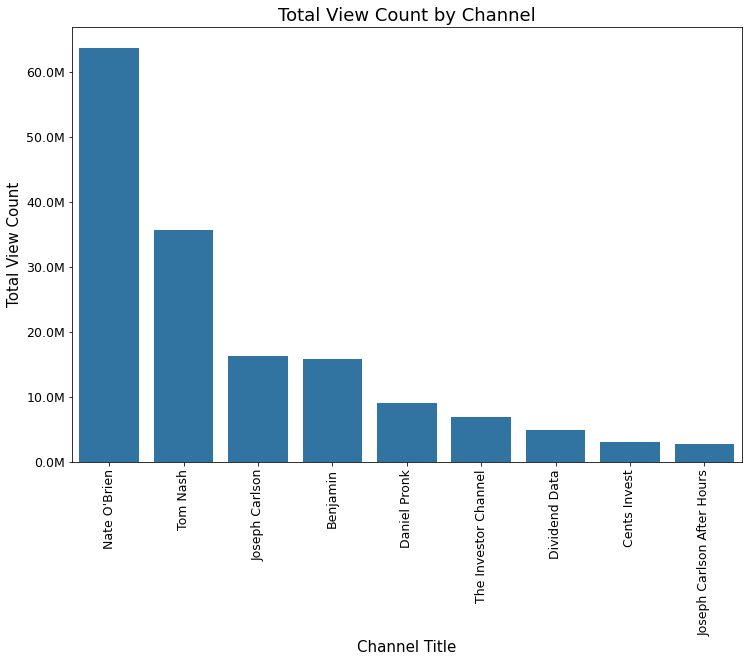

In [53]:
base_color = sb.color_palette()[0]
plt.figure(figsize = (12, 8))
ax = sb.barplot(x = 'channelTitle', y = 'viewCount', 
                data = video_df.groupby('channelTitle')['viewCount'].sum().sort_values(ascending = False).reset_index(),
               color = base_color)
ax.yaxis.set_major_formatter(formatter)

plt.title('Total View Count by Channel', fontsize = 18)
plt.xticks(rotation = 90, fontsize = 12.5)
plt.yticks(fontsize = 12.5)
plt.xlabel('Channel Title', fontsize = 15)
plt.ylabel('Total View Count', fontsize = 15);

**My first visualization has to do with viewing the sum of all view counts based on the channel. From the barplot above, we can see that Nate O'Brien has the most of them all with over 60 million views. That channel alone is almost double that of the 2nd place, which is Tom Nash.**

#### Video Upload Distribution By Day And Month

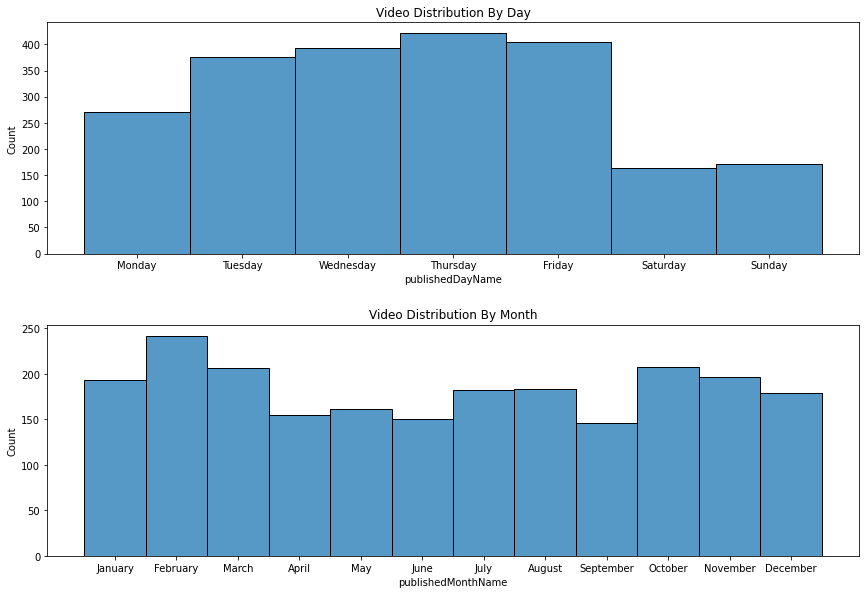

In [54]:
fig, ax = plt.subplots(2, 2, figsize = [12, 8])
fig.tight_layout(h_pad=5)

plt.subplot(2, 1, 1)
sb.histplot(data = video_df, x = "publishedDayName")
plt.title('Video Distribution By Day')

plt.subplot(2, 1, 2)
sb.histplot(data = video_df, x = "publishedMonthName")
plt.title('Video Distribution By Month');

**Next, I analyzed the distribution all the videos based on day and month. In the first plot, we can see that Thursday is the day with the most video uploads, but it doesn't seem like the rest of the weekdays are that far behind. However, if we take a look at the weekends, we find that the output is cut in half! This makes sense since the stock market is closed on the weekends.<br><br>
In the next plot, we see the video upload distribution by month. Although it seems like the upload rate is pretty consistent, the first and last 3 months ecperience a jolt of video uploads with all of them well above 150.**

#### Views vs. likes, comments & tags

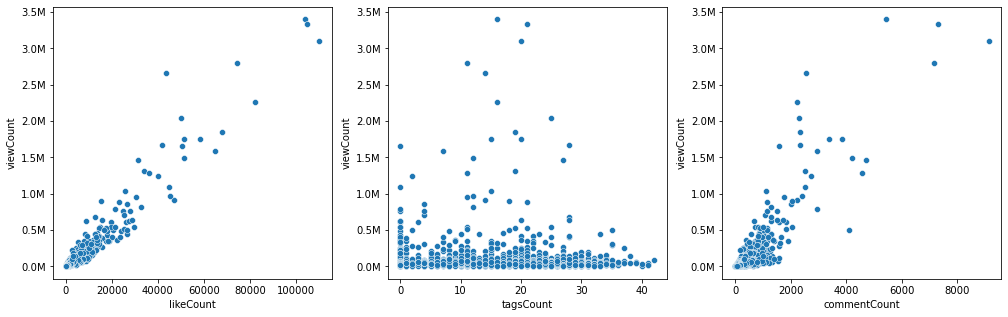

In [55]:
fig, ax = plt.subplots(1,3, figsize = [17, 5])

sb.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[0])
sb.scatterplot(data = video_df, x = 'tagsCount', y = 'viewCount', ax = ax[1])
sb.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[2])

# convert scietific notations on y-axis to millions
for i in range(3):
    ax[i].yaxis.set_major_formatter(formatter);

**In the first scatterplot, where we compare the relationship between likeCount and viewCount, we find a positive and strong relationship between the 2 variables. The more views one has, the more likes the video will most likely have. This makes sense, but there is a limitation to this. One can have a lot of views-say 500k views- and a lot of dislikes. Sadly, Youtube has removed that feature, so we won't be able to find out. <br><br> 
In the next plot, we can see a scatterplot that examines the relationship between viewCount and tagsCount. It literally forms a straight line across the bottom, which indicates that there isn't much of a relationship. In other words, it doesn't seem like tagsCount affects viewCount at all. What's interesting is that we see that most of the outliers are in-between the 10-30 tagsCount. <br><br>
In the final scatterplot, we see a positive relationship between viewCount and commentCount. This makes sense for the same reason the first scatter plot makes sense. However, I would characterize the strength as moderate because it seems like the data points are more spread out than the first plot.**

#### Distribution Of Video Duration

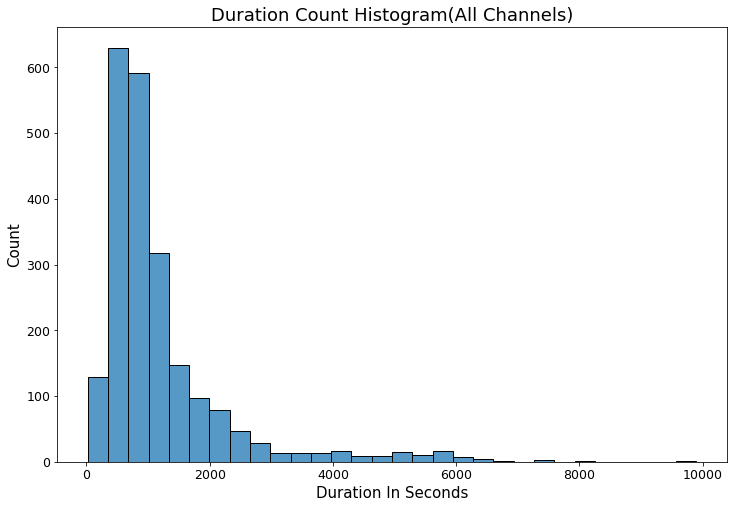

In [56]:
plt.figure(figsize = (12, 8))
sb.histplot(data=video_df, x="durationSec", bins = 30)

plt.title('Duration Count Histogram(All Channels)', fontsize = 18)
plt.xticks(fontsize = 12.5)
plt.yticks(fontsize = 12.5)
plt.xlabel('Duration In Seconds', fontsize = 15)
plt.ylabel('Count', fontsize = 15);

**In this histogam plot, we see that are huge majority of videos uploaded from all the channels are less than 2000 seconds which means that it skews to the left. The longest video is almost 10,000 seconds long!**

#### Comment Distribution Per Video

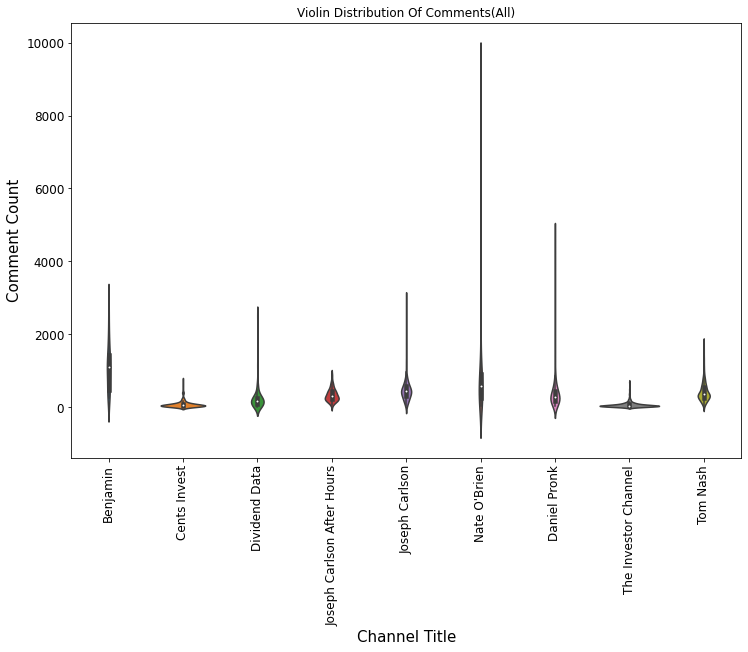

In [57]:
fig = plt.figure(figsize = (12, 8))
ax = sb.violinplot(data = video_df, x = 'channelTitle', y = 'commentCount')

plt.xticks(rotation = 90, fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Channel Title", fontsize = 15)
plt.ylabel("Comment Count", fontsize = 15)
plt.title("Violin Distribution Of Comments(All)");

**There are tons of outliers for Nate O'Brien which make it a little hard to analyze, so we will re-plot it. The only difference is that we will cut it off at Q3*2.**

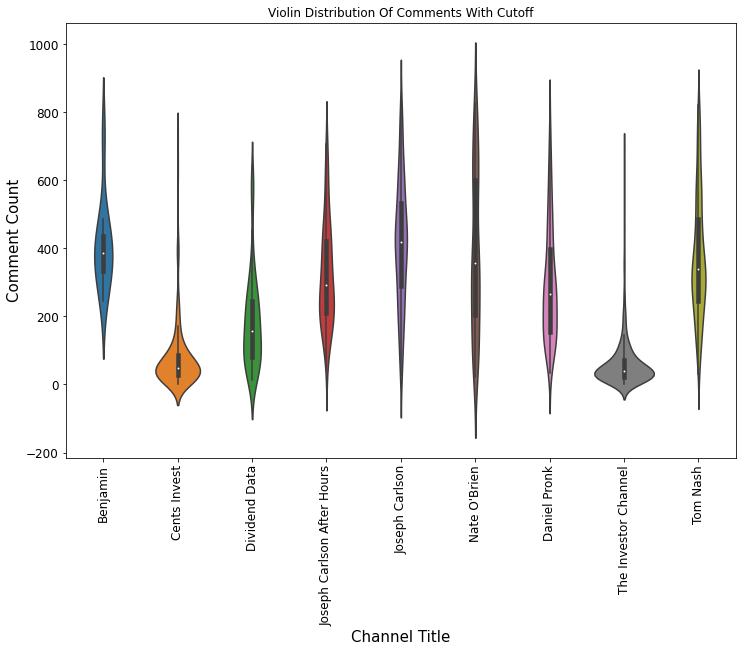

In [58]:
# establish cutoff point, get rid of outliers for better viewing
double_Q3 = (video_df['commentCount'].quantile(0.75))*2

#plot
fig = plt.figure(figsize = (12, 8))
ax = sb.violinplot(data = video_df[video_df.commentCount < double_Q3], x = 'channelTitle', y = 'commentCount')
plt.xticks(rotation = 90, fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Channel Title", fontsize = 15)
plt.ylabel("Comment Count", fontsize = 15)
plt.title("Violin Distribution Of Comments With Cutoff");

**Now that we have a much better look, we can properly analyze this violin plot of commentCount based on the channel. Please keep in mind that some channels and videos might have a lot more views than others. Look at how thin the violin plot is for Nate O'Brien. This is an indication of a large variance in their comments, which means some of the channel's videos get a lot more comments than others. We can say the same for both Joesph Carlson's channels and Tom Nash, but they seem to be more consistent. Other than those, all the other channels are more consistent. In other words, the wider the violin plot, the more consistent.**

#### View Distribution Per Video

In [59]:
# function similair to the million() function, but for thousands
def thousands(x, pos):
    """
    INPUT:
    x: numerical value
    pos: tick position
    
    OUTPUT: formatted string of % (x*1e-3) with K to represent thousands
    """
    return '%1.1fK' % (x*1e-3)

formatter = FuncFormatter(thousands)

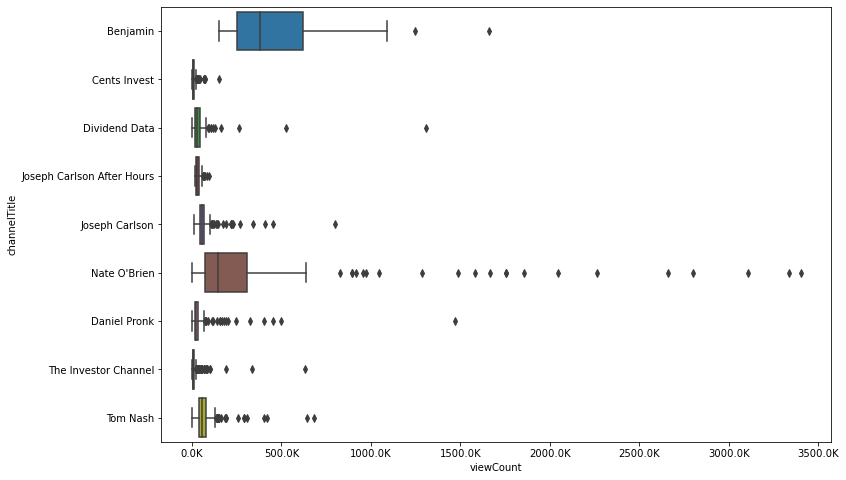

In [60]:
#plot
fig = plt.figure(figsize = (12, 8))
ax = sb.boxplot(data = video_df, y = 'channelTitle', x = 'viewCount')
ax.xaxis.set_major_formatter(formatter)

**Much like the last one, it's good to get a overview, but we should make a plot with a cutoff to get rid of the outliers.**

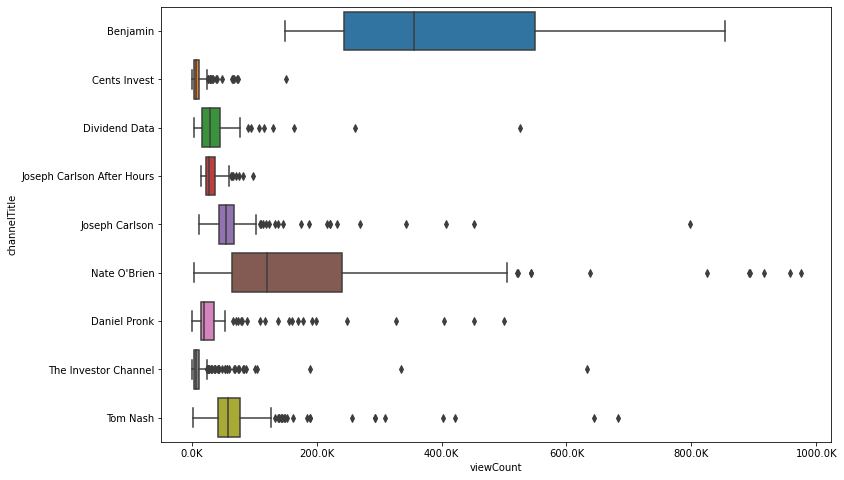

In [61]:
#plot
cutoff = 1000000

fig = plt.figure(figsize = (12, 8))
ax = sb.boxplot(data = video_df[video_df.viewCount < cutoff], y = 'channelTitle', x = 'viewCount')
ax.xaxis.set_major_formatter(formatter)

**In the second bar plot, we can clearly see that Benjamin has the highest median out of all the channels with a figure close to 400k. Nate O'Brien comes in second. Other than those two, we can see that the IQR for the other channels is much lower. Most of these channels' Q4s do not even cross 100k; as a result, we see a lot of outliers. For example, take a look at the Investor Channel, where there are tons of outliers.**

#### Average View Count Per Channel Based On Upload Day

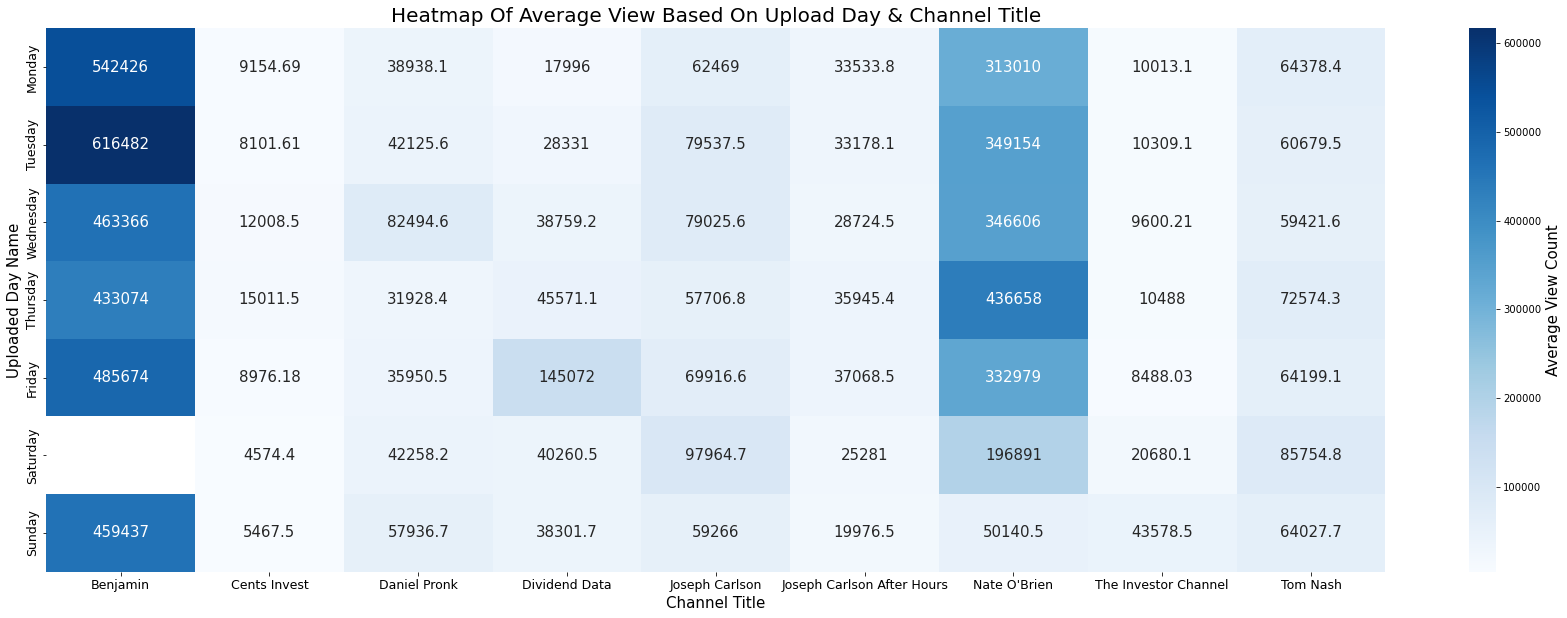

In [62]:
channel_view_means = video_df.groupby(['channelTitle', 'publishedDayName'])['viewCount'].mean().reset_index(name = 'viewAvg')
channel_view_means = channel_view_means.pivot(columns = 'channelTitle', index = 'publishedDayName', values = 'viewAvg')

fig = plt.figure(figsize = (30,10))
ax = sb.heatmap(channel_view_means, annot = True, cmap='Blues', 
                fmt='g', annot_kws = {'size': 15}, cbar_kws = {'label': 'Average View Count'})

plt.title('Heatmap Of Average View Based On Upload Day & Channel Title',
         fontsize = 20)
plt.xticks(rotation = 360, fontsize = 12.5)
plt.yticks(fontsize = 12.5)
plt.xlabel("Channel Title", fontsize = 15)
plt.ylabel("Uploaded Day Name", fontsize = 15)

# setting color bar fontsize 
# help: https://stackoverflow.com/questions/48586738/seaborn-heatmap-colorbar-label-font-size
ax.figure.axes[-1].yaxis.label.set_size(15);

**This heatmap displays each channel's average view based on the upload day. Starting from the highest mean, we see that Benjamin has some of the darkest shades of blue, which indicates the videos uploaded on those given days have the highest views out of all the channels. However, we also see a blank box also; this indicates that Benjamin has never uploaded a video on a Saturday. Benjamin has never averaged below 400k views for any given upload day. What's amazing is that the highest mean is 614k and the video was uploaded on a Tuesday! Keep in mind that Benjamin's channel started in 2021. Not enough time has passed to analyze the performance over time, but we can say that he went viral very quickly!<br><br>
Next, we see that the Nate O'Brien channel has the second darkest shades of blue. Most are not darker than any of Benjamin's. The highest mean for the Nate O'Brien channel is 437k for videos uploaded on Thursday. Cents Invest seems to average the lowest viewCount regardless of the day. Their highest average is only 15k and most of their averages are only 4 digits.**


### Video Title WordCloud

In [63]:
# funciton for plotting wordcloud
# word cloud help: https://www.youtube.com/watch?v=f1TJXu5H8ZM
def plot_youtube_cloud(data):
    """
    INPUT:
    data: Input data structure. 
    title: (str) Title of Word Cloud
    
    OUTPUT:
    No Output
    """
    # import youtube outline
    image = imageio.imread('youtube_image.png')
    wordcloud = WordCloud(background_color = 'white',
                         mask = image,
                         stopwords = stop_words,
                         max_words = 200,
                         max_font_size = 70,
                         scale = 3,
                         random_state =1,
                         # coloring help: https://github.com/amueller/word_cloud/issues/185
                         color_func=lambda *args, **kwargs: "red").generate(str(data))
    fig = plt.figure(1, figsize = (20,20), dpi=80)
    plt.axis('off')
    
    plt.imshow(wordcloud)
    plt.show()

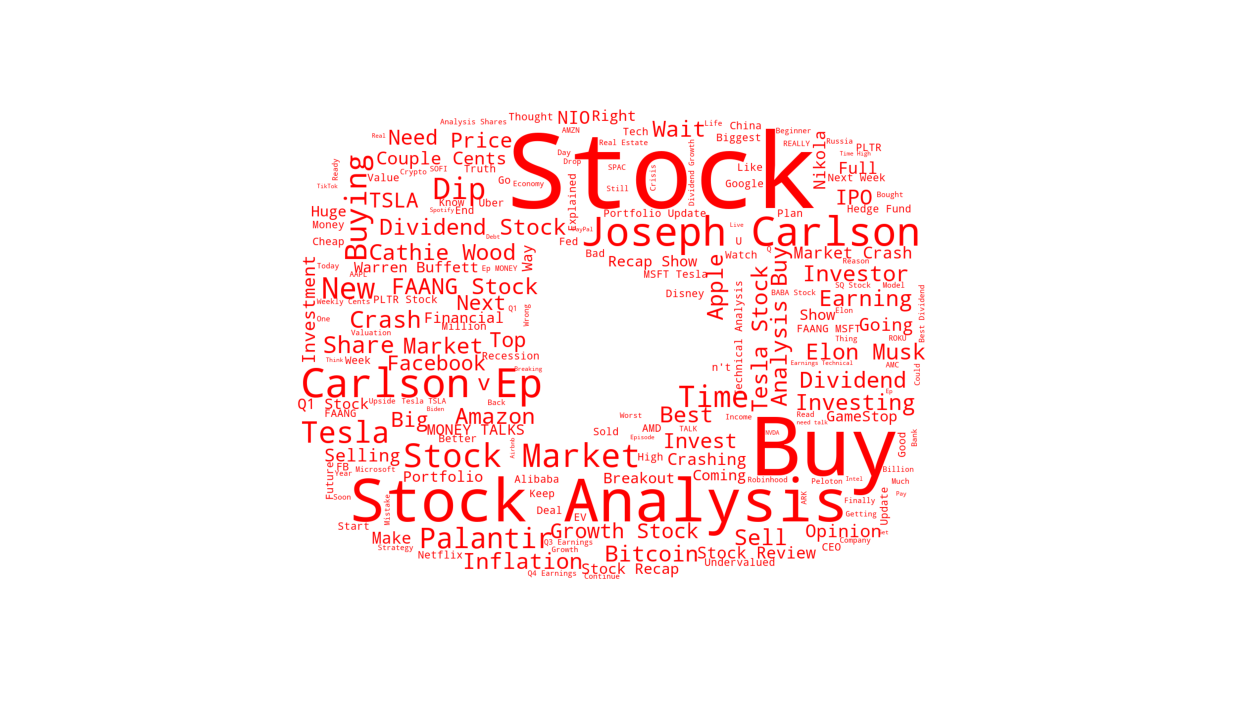

In [64]:
# setting up stop words
stop_words = set(stopwords.words('english'))
# word tokenization help: https://stackabuse.com/removing-stop-words-from-strings-in-python/
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [w for w in word_tokenize(x) if w not in stop_words])

# append all words 'title_no_stopwords' into single list
all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
# join all words together in list into single string
all_words_str = ' '.join(all_words)
plot_youtube_cloud(all_words_str)

**In the final analysis above, we see a word cloud in the shape of the Youtube logo. Most of the popular words in the video title are stock-related (no surprise). We see the following words/phrases have been used the most: 'Stock', 'Stock Analysis', and 'Buy'. Furthermore, as we examine more of the words, we find that the most-used words after those 3 are basically name-dropping, companies' names, investing terminologies, and stock ticker symbols.**

### Comments WordCloud

In [65]:
# join list of comments into a single string
for i in range(len(all_comments_df['comments'])):
    all_comments_df['comments'][i] = " ".join(all_comments_df['comments'][i])
all_comments_df['comments'].head()

0    Subscribe to The Daily Upside!\nhttps://bit.ly...
1    I consistently earn massively on my investment...
2    Subscribe to The Daily Upside! \nhttps://bit.l...
3    Subscribe to The Daily Upside!\nhttps://bit.ly...
4    I was trading options during the cold war LMAO...
Name: comments, dtype: object

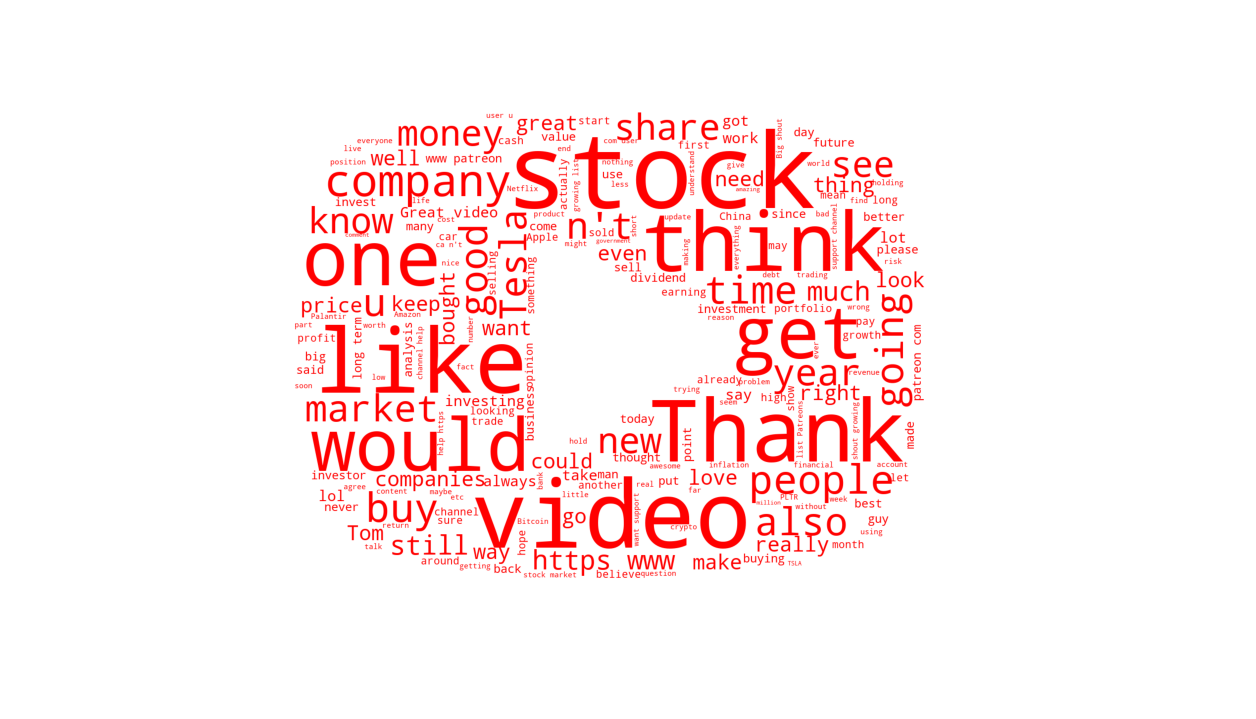

In [66]:
# new column for words not in stopwords
all_comments_df['comments_no_stopwords'] = all_comments_df['comments'].apply(lambda x: [w for w in word_tokenize(x) 
                                                                                        if w not in stop_words])
# append all words 'title_no_stopwords' into single list
all_words = list([a for b in all_comments_df['comments_no_stopwords'].tolist() for a in b])
# join all words together in list into single string
all_words_str = ' '.join(all_words)
plot_youtube_cloud(all_words_str)

**It seems like there are quite a number of similarities between the most-frequently-used words in the title and comments, but also a lot of differences. Some of the most frequently used words come as no surprise given the topic. These words include "stock", "company", "Thank" and various stock/company names. From the word cloud above, we can see that Tesla is the most talked about company in the comment section. Some of the differences that we spot between the title and comment word clouds are the verbs. In this word cloud, we can see that the most popular verbs are 'would' and 'think'. In the title word cloud, we saw that the most used verb is 'buy'.**

### Relationship between viewCount & title length

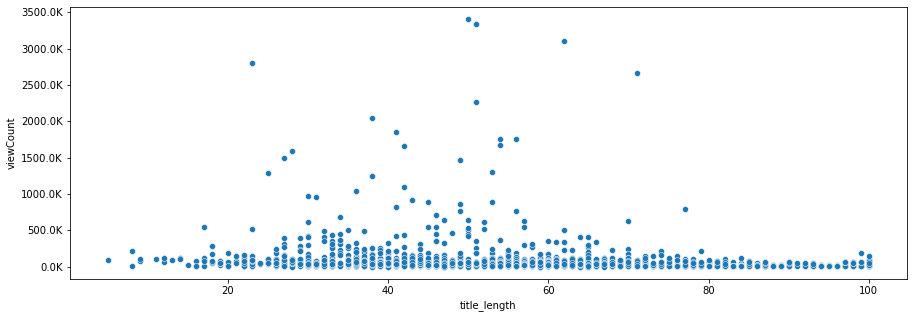

In [67]:
fig, ax = plt.subplots(figsize = [15, 5])
sb.scatterplot(data = video_df, x = 'title_length', y = 'viewCount')
ax.yaxis.set_major_formatter(formatter);

**From the scatterplot above, we can see that there is no relationship between the title length and word count. However, we can also see that the most viewed videos have between 20-80 characters.**

## Conclusion
In this project, we explored the video data collected from 9 different financial Youtube channels and made a number of interesting discoveries about the videos and the topics covered on these channels. To do a quick recap, we found the following:
- The more likes and comments a video has, the more views it'll most likely have. However, it seems the number of 'like' has a stronger positive relationship with the view count, which means that the more views a video has, the more people will like it.
- Most financial youtube videos are uploaded during the weekdays. Also, most were uploaded in the first 3 and last 3 months of the year. 
- Most of these financial youtube videos have 0-30 tags. 
- A majority of title length falls between 20-80, but anywhere between 20-60 tags seems to increase your chance at increasing your viewCount.
- The most frequently used word in the title and comment section is "stock". Furthermore, the comment section seems to be positive. Two words in the comment nordcloud that stood out to me were 'Thank' and 'think'. The second one is interesting because the commentator might be asking for the content creator's opinion on something which creates room for more content to be made.

Please do not take these findings seriously. Here are some limitations that this project has presented:
- There are only a total of 2201 videos in this dataset.
- These videos are collected from 9 YouTubers. Therefore, this isn't a good representation of all financial YouTube channels where there could be thousands.
- I only added the first 10 comments into the comments dataset.
- There are many factors that I haven't included in my analysis. Perhaps, the biggest one is the quality of the content itself.